# **Implementing Word2Vec with Logistic Regression and LSTM**

**CBOW (Continuous Bag-of-Words)** and **Skip-gram** are two popular algorithms used in natural language processing for generating word embeddings.

CBOW is a method that predicts the target word based on its context, which is a window of surrounding words. The goal of CBOW is to maximize the probability of predicting the target word given its context. In other words, CBOW learns to predict a word based on the words that surround it.

On the other hand, Skip-gram is the inverse of CBOW, where the algorithm predicts the context words given the target word. The goal of Skip-gram is to maximize the probability of predicting the context words given the target word.

The difference between CBOW and Skip-gram lies in their training objectives. CBOW is faster to train than Skip-gram because it involves predicting one target word from multiple context words, whereas Skip-gram predicts multiple context words from one target word. However, **Skip-gram is better at capturing rare and infrequent words, while CBOW is better at representing the overall meaning of a sentence**.

In summary, CBOW is a faster algorithm that predicts a target word based on its context, while Skip-gram is slower but better at capturing rare words by predicting context words given a target word. The choice of which algorithm to use depends on the specific application and the nature of the data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, auc

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

# keras
import keras
from keras.preprocessing.text import one_hot, Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, ReLU, Dropout, Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
# Read data from the first sheet
# This might take awhile...
path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/reviews.csv'
data = pd.read_csv(path)

In [ ]:
data.head()


,date,partially_cleaned_text,sentiment,cleaned_text
0,18/6/21,This is a very healthy dog food. Good for thei...,1,healthy dog food good digestion also good smal...
1,7/7/21,I've been very pleased with the Natural Balanc...,1,pleased natural balance dog food dogs issues d...
2,18/6/21,"Before I was educated about feline nutrition, ...",1,educated feline nutrition allowed cats become ...
3,7/7/21,"My holistic vet recommended this, along with a...",1,holistic vet recommended along brands tried ca...
4,1/7/21,I bought this coffee because its much cheaper ...,1,bought coffee much cheaper ganocafe organic re...


Text(0.5, 1.0, 'Distribution of Sentiment Labels')

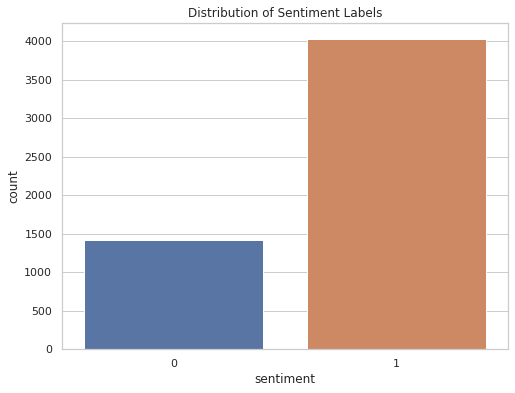

In [ ]:
# plot Distribution of Sentiment Labels, checking of imbalanced data
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=data, x='sentiment')
ax.set_title('Distribution of Sentiment Labels')

In [ ]:
# tokenise the cleaned text
data['cleaned_text_new'] = data['cleaned_text'].apply(
    lambda x: word_tokenize(x))

## Word2Vec + Neural Networks (ANN and LSTM)

From the Test Precision-Recall curve, we are able to derive that LSTM performs better than NN.

In [ ]:
# Train the CBOW architecture
w2v_model1 = gensim.models.Word2Vec(
    data['cleaned_text_new'], vector_size=100, window=5, min_count=2, sg=0)

In [ ]:
# Represents all of the words that our Word2Vec model learned a vector for (i.e all of the words that appeared in the training data at least twice)
w2v_model1.wv.index_to_key[0:20]


['like',
 'taste',
 'good',
 'great',
 'product',
 'would',
 'flavor',
 'one',
 'coffee',
 'love',
 'price',
 'really',
 'tea',
 'much',
 'get',
 'amazon',
 'food',
 'buy',
 'even',
 'use']

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(data['cleaned_text'])

# number of unique text in the data
vocab_size = len(tok.word_index) + 1
print('There are {} unique text in the data.'.format(vocab_size))


There are 12339 unique text in the data.


In [ ]:
# find the maximum length in each record
maxi = -1
for i, rev in enumerate(data['cleaned_text']):
    tokens = rev.split()
    if (len(tokens) > maxi):
        maxi = len(tokens)
print('The maximum length of the review for each record in the data is {}.'.format(maxi))

# max length of a review
max_rev_len = maxi + 1

# embedding dimension as choosen in word2vec constructor
embed_dim = 100

The maximum length of the review for each record in the data is 940.


In [ ]:
# this converts texts into some numeric sequences
encd_rev = tok.texts_to_sequences(data['cleaned_text'])

# we dont pad to a maximum length of 925 but use 50 if not the train data will be very sparse
pad_rev = pad_sequences(encd_rev, maxlen=50, padding='post')
pad_rev.shape

(5444, 50)

In [ ]:
# now creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():

    # check if word is in the vocabulary learned by the w2v model
    if word in w2v_model1.wv.index_to_key:
        # get the word vector from w2v model
        embed_matrix[i] = w2v_model1.wv[word]
    # else the embed_vector corressponding to that vector will stay zero.

In [ ]:
embed_matrix.shape


(12339, 100)

In [ ]:
# one hot target as required by NN.
Y = keras.utils.to_categorical(data['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(
    pad_rev, Y, test_size=0.20, random_state=11)

### NN

In [ ]:
# Build the NN Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim,
                    input_length=50, weights=[embed_matrix]))  # embeddings_initializer = Constant(embed_matrix)))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation = 'relu'))
# model.add(Dropout(0.20))
model.add(Dense(2, activation='sigmoid'))
#model.add(Dense(2, activation = 'softmax'))

In [ ]:
model.compile(optimizer='adam', metrics=['acc'],  loss='binary_crossentropy')

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           1233900   
                                                                 
 flatten_2 (Flatten)         (None, 5000)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                80016     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,313,950
Trainable params: 1,313,950
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Run NN

start = time.time()
history_embedding = model.fit(
    X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

end = time.time()
print("Time taken to run model: {} seconds.".format(end - start))

Epoch 1/15
69/69 [==============================] - 2s 16ms/step - loss: 0.6088 - acc: 0.7334 - val_loss: 0.5538 - val_acc: 0.7300
Epoch 2/15
69/69 [==============================] - 1s 14ms/step - loss: 0.5721 - acc: 0.7428 - val_loss: 0.5439 - val_acc: 0.7300
Epoch 3/15
69/69 [==============================] - 1s 14ms/step - loss: 0.5390 - acc: 0.7428 - val_loss: 0.5141 - val_acc: 0.7300
Epoch 4/15
69/69 [==============================] - 1s 17ms/step - loss: 0.4754 - acc: 0.7428 - val_loss: 0.4662 - val_acc: 0.7300
Epoch 5/15
69/69 [==============================] - 2s 30ms/step - loss: 0.4099 - acc: 0.7428 - val_loss: 0.4329 - val_acc: 0.7300
Epoch 6/15
69/69 [==============================] - 2s 34ms/step - loss: 0.3327 - acc: 0.7428 - val_loss: 0.4035 - val_acc: 0.7300
Epoch 7/15
69/69 [==============================] - 2s 31ms/step - loss: 0.2945 - acc: 0.7428 - val_loss: 0.4083 - val_acc: 0.8035
Epoch 8/15
69/69 [==============================] - 1s 20ms/step - loss: 0.2644 - a

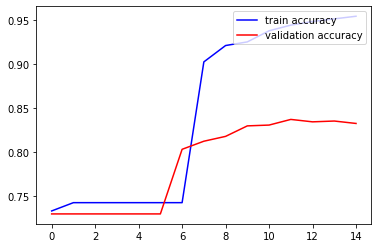

In [ ]:
plt.plot(history_embedding.history['acc'], c='b', label='train accuracy')
plt.plot(history_embedding.history['val_acc'],
         c='r', label='validation accuracy')
plt.legend(loc='upper right')
plt.show()

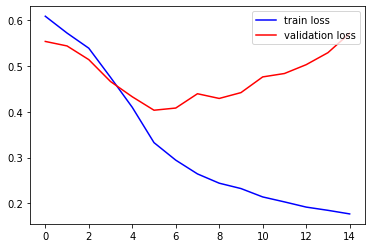

In [ ]:
plt.plot(history_embedding.history['loss'], c='b', label='train loss')
plt.plot(history_embedding.history['val_loss'], c='r', label='validation loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# predict the response on the test data
NN_y_pred = model.predict(X_test)

# get the predicted test response
NN_test_pred = []
for pred in NN_y_pred:
    if pred[0] >= 0.5:
        NN_test_pred.append(0)
    else:
        NN_test_pred.append(1)


# get actual test response
test_actual = []
for pred in y_test:
    if pred[0] >= 0.5:
        test_actual.append(0)
    else:
        test_actual.append(1)

35/35 [==============================] - 0s 2ms/step


In [ ]:
# classification report for NN
print(classification_report(test_actual, NN_test_pred, labels=[0, 1]))


              precision    recall  f1-score   support

           0       0.90      0.43      0.58       294
           1       0.82      0.98      0.90       795

    accuracy                           0.83      1089
   macro avg       0.86      0.71      0.74      1089
weighted avg       0.84      0.83      0.81      1089



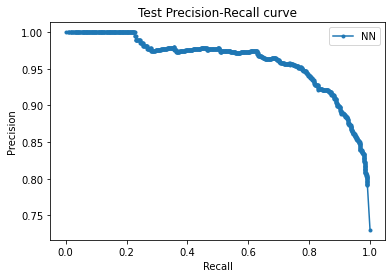

In [ ]:
# keep probabilities for the positive outcome only
NN_y_probs = NN_y_pred[:, 1]

# plot the Test Precision-Recall curve
NN_precision, NN_recall, thresholds = precision_recall_curve(
    test_actual, NN_y_probs)
plt.plot(NN_recall, NN_precision,  marker='.', label="NN")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Test Precision-Recall curve")

In [ ]:
auc(NN_recall, NN_precision)


0.957988966352506

In [ ]:
average_precision_score(test_actual, NN_y_probs)


0.9577813711375313

### LSTM

In [ ]:
# Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim,
                    input_length=50, weights=[embed_matrix]))  # embeddings_initializer = Constant(embed_matrix)))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
# compile the model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=5e-4),
              loss='binary_crossentropy', metrics=['accuracy'])


file_path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM260323.h5'

checkpoint = ModelCheckpoint(
    file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
)

# reduce_on_plateau = ReduceLROnPlateau(
#     monitor="val_accuracy", factor=0.1, patience=2, verbose=1, min_delta=1e-2
# )

early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, verbose=2, min_delta=1e-2
)

callbacks_list = [checkpoint, early_stopping]

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           1233900   
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,353,246
Trainable params: 1,353,246
No

In [ ]:
# learning rate 5e-4
# fitting the LSTM model

start = time.time()
history_embedding = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(
    X_test, y_test), callbacks=callbacks_list)

end = time.time()
print("Time taken to run model: {} seconds.".format(end - start))

Epoch 1/15
68/69 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.7369
Epoch 1: val_accuracy improved from -inf to 0.73003, saving model to /content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM260323.h5
69/69 [==============================] - 10s 115ms/step - loss: 0.5904 - accuracy: 0.7371 - val_loss: 0.5930 - val_accuracy: 0.7300
Epoch 2/15
68/69 [============================>.] - ETA: 0s - loss: 0.5603 - accuracy: 0.7468
Epoch 2: val_accuracy did not improve from 0.73003
69/69 [==============================] - 7s 96ms/step - loss: 0.5602 - accuracy: 0.7470 - val_loss: 0.6091 - val_accuracy: 0.7300
Epoch 3/15
68/69 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7746
Epoch 3: val_accuracy improved from 0.73003 to 0.80900, saving model to /content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM260323.h5
69/69 [==============================] - 9s 130ms/step - loss: 0.5187 - accuracy: 0.7747 - val_loss: 0.4924 - val_accuracy: 

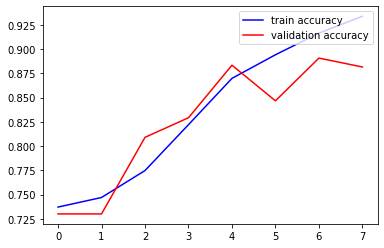

In [ ]:
plt.plot(history_embedding.history['accuracy'], c='b', label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],
         c='r', label='validation accuracy')
plt.legend(loc='upper right')
plt.show()

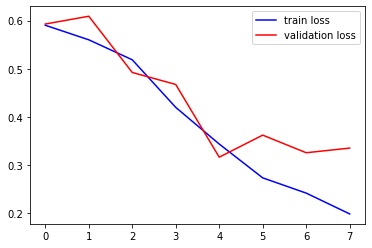

In [ ]:
plt.plot(history_embedding.history['loss'], c='b', label='train loss')
plt.plot(history_embedding.history['val_loss'], c='r', label='validation loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# use the best model
file_path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/LSTM260323.h5'
new_model = load_model(file_path)


In [ ]:
# predict the response on the test data
LSTM_y_pred = new_model.predict(X_test)

# get the predicted test response
LSTM_test_pred = []
for pred in LSTM_y_pred:
    if pred[0] >= 0.5:
        LSTM_test_pred.append(0)
    else:
        LSTM_test_pred.append(1)


# get actual test response
test_actual = []
for pred in y_test:
    if pred[0] >= 0.5:
        test_actual.append(0)
    else:
        test_actual.append(1)

35/35 [==============================] - 1s 20ms/step


In [ ]:
# classification report for NN
print(classification_report(test_actual, LSTM_test_pred, labels=[0, 1]))


              precision    recall  f1-score   support

           0       0.87      0.70      0.78       294
           1       0.90      0.96      0.93       795

    accuracy                           0.89      1089
   macro avg       0.88      0.83      0.85      1089
weighted avg       0.89      0.89      0.89      1089



In [ ]:
LSTM_y_probs = LSTM_y_pred[:, 1]
LSTM_precision, LSTM_recall, LSTM_thresholds = precision_recall_curve(
    test_actual, LSTM_y_probs)

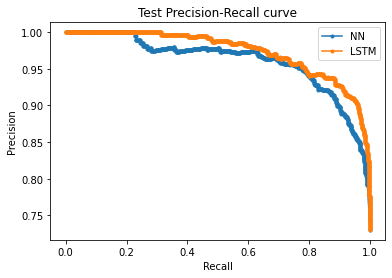

In [ ]:
# keep probabilities for the positive outcome only
NN_y_probs = NN_y_pred[:, 1]
LSTM_y_probs = LSTM_y_pred[:, 1]

# plot the Test Precision-Recall curve
NN_precision, NN_recall, NN_thresholds = precision_recall_curve(
    test_actual, NN_y_probs)
LSTM_precision, LSTM_recall, LSTM_thresholds = precision_recall_curve(
    test_actual, LSTM_y_probs)
plt.plot(NN_recall, NN_precision,  marker='.', label="NN")
plt.plot(LSTM_recall, LSTM_precision,  marker='.', label="LSTM")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Test Precision-Recall curve")

In [ ]:
auc(LSTM_recall, LSTM_precision)


0.9735675336159264

In [ ]:
average_precision_score(test_actual, LSTM_y_probs)


0.9735871503964051